In [ ]:
# For read excel format form pandas
!pip install openpyxl
# For Vietnamese word_segment
!pip install pyvi
!pip install torch
!pip install spicy
!pip install transformers
!pip install gensim

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from numpy import triu
from pyvi import ViTokenizer
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 4
N_SPLITS = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

def get_data(path):
    df = pd.read_csv(path, usecols=[0, 1, 2, 3, 4])  # dùng 5 cột đầu
    df.columns = ['ID khách sạn', 'Ngày đánh giá', 'Điểm đánh giá', 'Nội dung đánh giá', 'Cảm xúc']
    return df

train_file_path = "/content/drive/MyDrive/Final_AI/train_AI.csv"
valid_file_path = "/content/drive/MyDrive/Final_AI/valid_AI.csv"
test_file_path = "/content/drive/MyDrive/Final_AI/test_AI.csv"

train_df = get_data(train_file_path)
valid_df = get_data(valid_file_path)
test_df = get_data(test_file_path)

full_train_df = pd.concat([train_df, valid_df], ignore_index=True)
full_train_df["kfold"] = -1

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(skf.split(X=full_train_df, y=full_train_df["Cảm xúc"])):
    full_train_df.loc[val_idx, "kfold"] = fold


In [ ]:

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"<.*?>", "", text)  # xóa thẻ HTML
    text = re.sub(r"[^a-zA-Z0-9À-ỹà-ỹ_ ]", "", text)  # xóa ký tự đặc biệt
    text = re.sub(r"\s+", " ", text).strip()  # xóa khoảng trắng thừa
    return text

# Bước 3: Hàm tách từ kết hợp làm sạch
def segment_text(text):
    text = clean_text(text)
    return ViTokenizer.tokenize(text)

# Bước 4: Áp dụng cho cả 3 tập
for df in [train_df, valid_df, test_df]:
    df["seg_text"] = df["Nội dung đánh giá"].astype(str).apply(segment_text)

# Bước 5: Mã hóa nhãn cảm xúc
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["Cảm xúc"])
valid_df["label"] = label_encoder.transform(valid_df["Cảm xúc"])
test_df["label"]  = label_encoder.transform(test_df["Cảm xúc"])



In [ ]:
train_df.sample(5)

,ID khách sạn,Ngày đánh giá,Điểm đánh giá,Nội dung đánh giá,Cảm xúc,seg_text,label
2976,665815,25 tháng 6 2019,10,"Tôi ở tầng 52, rất tuyệt vì có thể ngắm toàn c...",Happy,tôi ở tầng 52 rất tuyệt vì có_thể ngắm toàn_cả...,2
6418,5586857,23 tháng 2 2025,"7,6",Phòng family hơi nhỏ.,Depressed,phòng family hơi nhỏ,1
5476,184445,10 tháng 12 2024,9.5,"Bữa sáng được phục vụ được, tôi hy vọng lần sa...",Hopeful,bữa sáng được phục_vụ được tôi hy_vọng lần sau...,3
2531,161666,08 tháng 11 2022,5,Bữa sáng. Căn phòng tối om. Tôi không thể lấy ...,Depressed,bữa sáng căn phòng tối_om tôi không_thể lấy đư...,1
2839,665815,21 tháng 6 2022,"6,8",Đặt phòng dưới khách sạn nhưng cuối cùng lại c...,Depressed,đặt phòng dưới khách_sạn nhưng cuối_cùng lại c...,1


In [ ]:
valid_df.sample(5)

,ID khách sạn,Ngày đánh giá,Điểm đánh giá,Nội dung đánh giá,Cảm xúc,seg_text,label
179,54789688,20 tháng 1 năm 2024,5,Nơi này đã làm tốt nhiệm vụ nhưng tôi sẽ không...,Depressed,nơi này đã làm tốt nhiệm_vụ nhưng tôi sẽ không...,1
115,2614689,01 tháng 12 2023,"9,6",Nhân viên rất tử tế và làm cho bạn cảm thấy th...,Happy,nhân_viên rất tử_tế và làm cho bạn cảm_thấy th...,2
466,161666,23 tháng 10 2023,9,Khách sạn nằm rất gần phố cổ và Hồ Hoàn Kiếm t...,Happy,khách_sạn nằm rất gần phố cổ và hồ hoàn kiếm t...,2
876,184445,24 tháng 3 2022,9.1,"Tạm ổn trong tầm giá phù hợp, sẽ là lựa chọn t...",Hopeful,tạm ổn trong tầm giá phù_hợp sẽ là lựa_chọn tố...,3
794,96589668,4 tháng 3 2022,10,Thái độ nhân viên thật đáng nhớ. Nếu có dịch v...,Hopeful,thái_độ nhân_viên thật đáng nhớ nếu có dịch_vụ...,3


In [ ]:
test_df.sample(5)

,ID khách sạn,Ngày đánh giá,Điểm đánh giá,Nội dung đánh giá,Cảm xúc,seg_text,label
225,73534968,25 tháng 5 2024,7.7,Dịch vụ dọn phòng mang lại cảm giác như ở nhà....,Hopeful,dịch_vụ dọn phòng mang lại cảm_giác như ở nhà ...,3
587,665815,02 tháng 12 2019,"9,6",Rẻ hơn các khách sạn Lotte khác trong khu vực ...,Happy,rẻ hơn các khách_sạn lotte khác trong khu_vực ...,2
358,54789688,9 tháng 6 năm 2021,10,phòng bẩn,Angry,phòng bẩn,0
485,96589668,25 tháng 4 2024,7.2,Thái độ nhân viên mang lại cảm giác như ở nhà....,Hopeful,thái_độ nhân_viên mang lại cảm_giác như ở nhà ...,3
519,25718207,14 tháng 12 2024,8.1,Không gian nghỉ dưỡng thật đáng nhớ. Nếu có dị...,Hopeful,không_gian nghỉ_dưỡng thật đáng nhớ nếu có dịc...,3


In [ ]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8432 entries, 0 to 8431
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID khách sạn       8432 non-null   int64 
 1   Ngày đánh giá      8432 non-null   object
 2   Điểm đánh giá      8432 non-null   object
 3   Nội dung đánh giá  8432 non-null   object
 4   Cảm xúc            8432 non-null   object
 5   seg_text           8432 non-null   object
 6   label              8432 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 461.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID khách sạn       1055 non-null   int64 
 1   Ngày đánh giá      1055 non-null   object
 2   Điểm đánh giá      1055 non-null   object
 3   Nội dung đánh giá  1055 non-null   object
 4   Cảm xúc            1055 no

(None, None)

# Biểu đồ thể hiện sự phân bố của các nhãn cảm xúc

<Axes: xlabel='Cảm xúc', ylabel='count'>

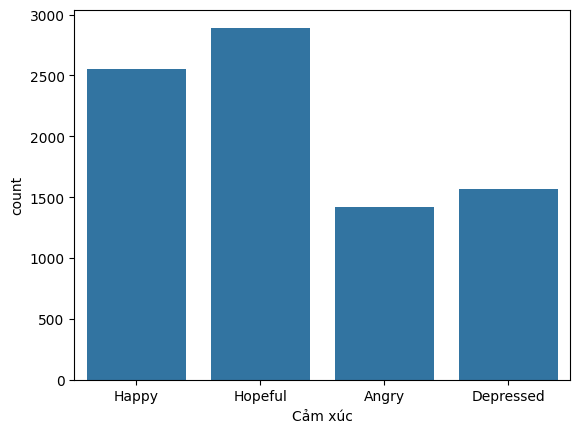

In [ ]:
sns.countplot(x='Cảm xúc', data=train_df)

# Khởi tạo mô hình tokenizer từ PhoBERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

#Tùy chỉnh Dataset
- "_getitem_" Lấy 1 mẫu dữ liệu, xử lý, tokenizer, mã hóa.
- _labelencoder_ Số hóa Label
- _"get_input_data"_ Làm sạch và phân tách văn bản
- _"encode_plus"_ Dùng tokenizer (PhoBERT) để tạo input_ids và attention_mask


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }
    def labelencoder(self,text):
        if text=='Happy':
            return 0
        elif text=='Depressed':
            return 1
        elif text=='Angry':
            return 2
        elif text=='Hopeful':
            return 3
        else:
            return 4

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Nội dung đánh giá']
        text = ' '.join(simple_preprocess(text))
        text = ViTokenizer.tokenize(text)
        label = self.labelencoder(row['Cảm xúc'])
        return text, label

#Token Count: Đánh giá độ dài văn bản

Text(0.5, 9.444444444444438, 'Token Count')

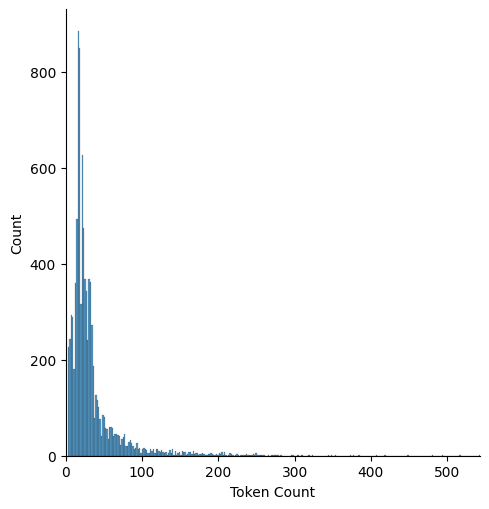

In [ ]:
all_data = train_df['Nội dung đánh giá'].tolist() + test_df["Nội dung đánh giá"].tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [ ]:
def train(model, criterion, optimizer, train_loader, lr_scheduler, device):
    model.train()
    losses = []
    correct = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_masks'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, targets)
        _, preds = torch.max(outputs, dim=1)

        correct += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f"Train Accuracy: {correct.double()/len(train_loader.dataset):.4f} | Loss: {np.mean(losses):.4f}")


In [ ]:
def evaluate(model, criterion, loader, device, is_test=False):
    model.eval()
    losses = []
    correct = 0
    real_vals = []
    pred_vals = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_masks'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, targets)

            correct += torch.sum(preds == targets)
            losses.append(loss.item())
            real_vals.extend(targets.cpu().numpy())
            pred_vals.extend(preds.cpu().numpy())

    acc = correct.double() / len(loader.dataset)
    label = "Test" if is_test else "Valid"
    print(f"{label} Accuracy: {acc:.4f} | Loss: {np.mean(losses):.4f}")
    return real_vals, pred_vals

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
def save_model_and_tokenizer(model, tokenizer):
    torch.save(model.state_dict(), "best_model.pth")
    tokenizer.save_pretrained("phobert_tokenizer/")

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [ ]:
from sklearn.model_selection import StratifiedKFold

train_df["kfold"] = -1

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(train_df, y=train_df["Cảm xúc"])):
    train_df.loc[val_idx, "kfold"] = fold

Epoch 1
Train Accuracy: 0.7876 | Loss: 0.5586
Epoch 2
Train Accuracy: 0.9120 | Loss: 0.2500
Epoch 3
Train Accuracy: 0.9357 | Loss: 0.1888
Epoch 4
Train Accuracy: 0.9516 | Loss: 0.1539
Test Accuracy: 0.9147 | Loss: 0.2574


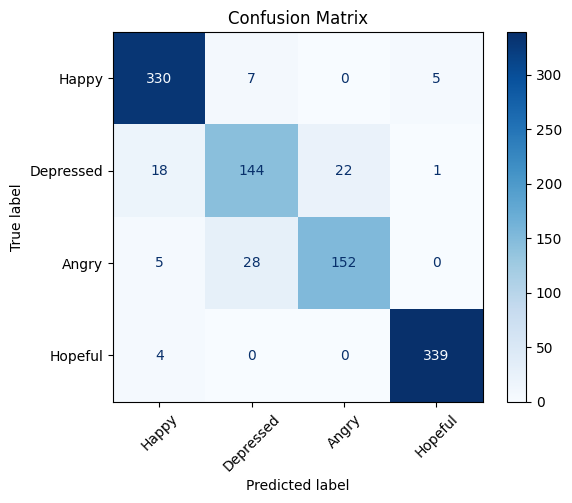

              precision    recall  f1-score   support

       Happy       0.92      0.96      0.94       342
   Depressed       0.80      0.78      0.79       185
       Angry       0.87      0.82      0.85       185
     Hopeful       0.98      0.99      0.99       343

    accuracy                           0.91      1055
   macro avg       0.90      0.89      0.89      1055
weighted avg       0.91      0.91      0.91      1055



In [ ]:
# Setup
from transformers import get_linear_schedule_with_warmup # Added this import
from sklearn.metrics import ConfusionMatrixDisplay # Added this import


class_names = ["Happy", "Depressed", "Angry", "Hopeful"]
n_classes = len(class_names)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

# Data
train_df = pd.read_csv("/content/drive/MyDrive/Final_AI/train_AI.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Final_AI/test_AI.csv")
train_dataset = SentimentDataset(train_df, tokenizer, max_len=50)
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 4
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps) # Changed get_scheduler to get_linear_schedule_with_warmup

# Train
for epoch in range(4):
    print(f"Epoch {epoch+1}")
    train(model, criterion, optimizer, train_loader, lr_scheduler, device)

# Eval
real, pred = evaluate(model, criterion, test_loader, device, is_test=True)
plot_confusion_matrix(real, pred, class_names)
save_model_and_tokenizer(model, tokenizer)

In [ ]:
def test_kfold(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=4)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
def check_wrong(real, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real, pred)
    print(test_df.iloc[wrong_arr[i]]["Nội dung đánh giá"])
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real[wrong_arr[i]]]})')

--------------------------------------------------
Phòng ở sạch nhưng nước nóng chạy bằng năng lượng mặt trời nên những ngày không có nắng to thì khi tắm biển xong lên tắm là bị lạnh với ng già trẻ nhỏ. Các món ăn trong khách sạn với mình là không ngon lắm, nhưng còn tùy thuộc vào khẩu vị của từng người

Predicted: (Depressed) --vs-- Real label: (Angry)
--------------------------------------------------
Không có tên khách sạn nào ở bên ngoài nên tôi không thể biết được trừ khi có nhân viên bảo vệ gọi tôi. Về chỗ ở, nơi này có đầy đủ tiện nghi, có vòi sen nước nóng và một căn bếp đơn giản nên rất tuyệt. Tôi không biết cách quay phim TV nên không thể xem được. Tôi mang theo một chiếc máy tính bảng nên không thành vấn đề, nhưng quả thực rất đáng thất vọng.
Predicted: (Happy) --vs-- Real label: (Depressed)
--------------------------------------------------
Không có gì. Quảng cáo sai lệch về bất động sản
Predicted: (Depressed) --vs-- Real label: (Angry)
-------------------------------------

In [ ]:
def infer(text, tokenizer, max_len=120):
    print(f'Text: {text}')
    text = ' '.join(simple_preprocess(text))
    text = ViTokenizer.tokenize(text)

    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Sentiment: {class_names[y_pred]}')

In [ ]:
models = []
# Load the single trained model
model = SentimentClassifier(n_classes=4)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()
models.append(model)

In [ ]:
torch.save(models, "all_folds_models.pt")


In [ ]:
if os.path.exists("all_folds_models.pt"):
    print("✅ File 'all_folds_models.pt' đã tồn tại. Đang tải lại danh sách mô hình...")
    models = torch.load("all_folds_models.pt", map_location=device, weights_only=False)
    for model in models:
        model.to(device)
        model.eval()
else:
    print("🚀 Chưa có file 'all_folds_models.pt'. Đang tải từng mô hình từ file .pth...")
    models = []
    for fold in range(1, 6):
        model = SentimentClassifier(n_classes=4)
        model.load_state_dict(torch.load(f"phobert_fold{fold}.pth", map_location=device))
        model.to(device)
        model.eval()
        models.append(model)

    torch.save(models, "all_folds_models.pt")
    print("✅ Đã lưu tất cả mô hình vào file 'all_folds_models.pt'")

✅ File 'all_folds_models.pt' đã tồn tại. Đang tải lại danh sách mô hình...


In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
models = torch.load("all_folds_models.pt", map_location=device, weights_only=False)
for model in models:
    model.eval()

In [ ]:
from pyvi import ViTokenizer
from gensim.utils import simple_preprocess
from transformers import AutoTokenizer
import torch # Added torch import

# Load tokenizer PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

# Danh sách nhãn (đổi theo labelencoder bạn dùng)
label_map = {
    0: "Happy",
    1: "Depressed",
    2: "Angry",
    3: "Hopeful"
}

def preprocess_text(text):
    text = ' '.join(simple_preprocess(text))
    return ViTokenizer.tokenize(text)

def predict_text(text, model, tokenizer, max_len=120):
    text = preprocess_text(text)

    encoding = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

    input_ids = encoding["input_ids"].to(device) # Moved to device
    attention_mask = encoding["attention_mask"].to(device) # Moved to device

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    return label_map.get(pred_class, "Unknown"), probs.cpu().numpy() # Moved back to cpu for numpy conversion

In [ ]:
text = "Phòng rất bẩn"
label, probs = predict_text(text, model, tokenizer)
print("Dự đoán cảm xúc:", label)
print("Xác suất:", probs)


Dự đoán cảm xúc: Angry
Xác suất: [[0.0032888  0.21242869 0.77899635 0.00528625]]
